In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)
X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=True: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [3]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 3 # Each HybridSN takes 1 hour to run with m=3 and PCA->30
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=False)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=False)
#######################################################

X_train_HS.shape, X_test_HS.shape

((126, 56, 56, 30), (57, 56, 56, 30))

# Test HybridSN

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_2 (Reshape)          (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0   

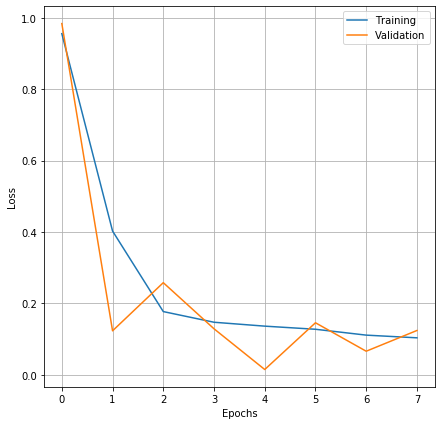

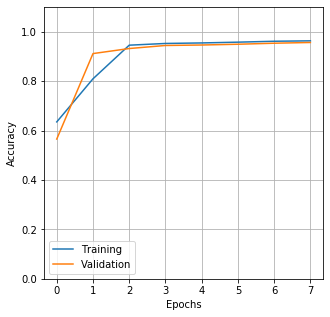

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     33010
         1.0       0.94      0.96      0.95     23649
         2.0       0.72      0.55      0.62      1709

    accuracy                           0.96     58368
   macro avg       0.88      0.83      0.85     58368
weighted avg       0.96      0.96      0.96     58368



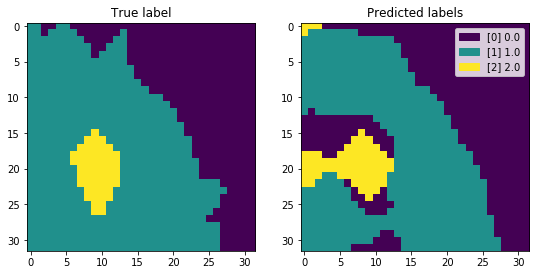

Elapsed time: 467.5118 seconds
Fasle positive blobs 44.
Fasle positive blobs per image 0.7719


In [6]:
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=8)
timer.stop()

model.plot_training_results()
# model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test_HS)

In [3]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

m = 5
X_train_svm, Y_train_svm = zoom(X_train_orig, Y_train_orig, s, m)
X_test_svm,  Y_test_svm  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (-7.476554870605469, 12.313852310180664) (570, 32, 32, 208) (1260, 32, 32, 208)
(array([0., 1., 2.]), array([1049404,  226419,   14417]))
(array([0., 1., 2.]), array([454977, 121779,   6924]))


# Testing SVM

In [6]:
# Started the training at ~16:30
# Finished training at ~17:00

In [7]:
Y_train_orig.shape, Y_test_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1))

In [8]:
Y_train_svm.shape, Y_test_svm.shape

((210, 32, 32, 1), (95, 32, 32, 1))

Elapsed time: 211.9660 seconds
Elapsed time: 89.6961 seconds
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    177893
         1.0       0.99      0.99      0.99     33938
         2.0       0.99      0.97      0.98      3209

    accuracy                           1.00    215040
   macro avg       0.99      0.98      0.99    215040
weighted avg       1.00      1.00      1.00    215040

Elapsed time: 40.5647 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     74780
         1.0       0.98      0.96      0.97     21673
         2.0       0.87      0.70      0.78       827

    accuracy                           0.99     97280
   macro avg       0.95      0.89      0.91     97280
weighted avg       0.99      0.99      0.99     97280

Fasle positive blobs 24.
Fasle positive blobs per image 0.2526


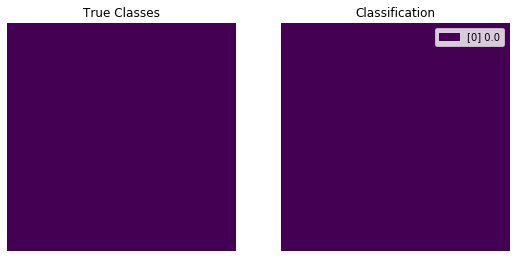

In [9]:
from sklearn import svm
from sklearn.metrics import classification_report

svm = mypackage.SVM(X_train_svm, Y_train_svm)
svm.train()
svm.predict(X_train_svm, Y_train_svm, plot=False)
Y_hat = svm.predict(X_test_svm, Y_test_svm)

mypackage.report_count_false_positive(Y_hat, Y_test_svm)

In [10]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

Elapsed time: 12.9107 seconds
Elapsed time: 0.1832 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1080250
         1.0       0.96      0.96      0.96    196825
         2.0       0.91      0.62      0.73     13165

    accuracy                           0.99   1290240
   macro avg       0.95      0.86      0.90   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 0.0679 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    455078
         1.0       0.98      0.95      0.96    122417
         2.0       0.89      0.68      0.77      6185

    accuracy                           0.98    583680
   macro avg       0.95      0.88      0.91    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 63.
Fasle positive blobs per image 0.1105


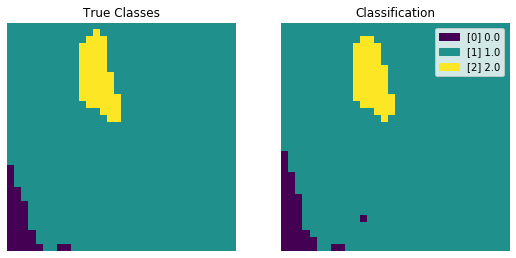

In [11]:
logreg = mypackage.LogReg(X_train, Y_train, C=1e5, max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

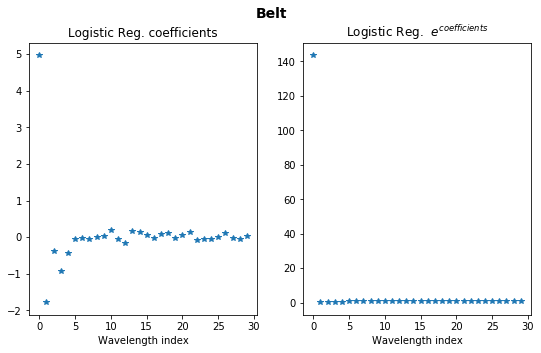

Ordered four most useful wavelengths are: [928, 964, 975, 1004]nm
There corresponding indexes are: [ 0 10 13 21]


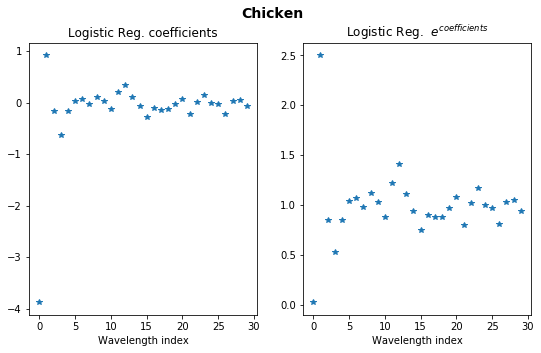

Ordered four most useful wavelengths are: [932, 971, 968, 1011]nm
There corresponding indexes are: [ 1 12 11 23]


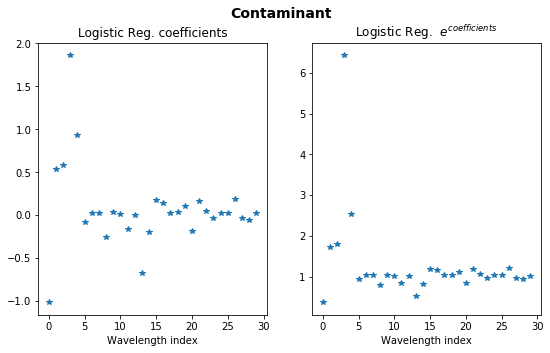

Ordered four most useful wavelengths are: [939, 942, 935, 932]nm
There corresponding indexes are: [3 4 2 1]


In [13]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [4]:
# mypackage.plot_labeled_images(Y_hat, Y_test)

In [ ]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.8855
Epoch 00001: val_loss improved from inf to 0.13321, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 12s 11ms/sample - loss: 0.5048 - accuracy: 0.8861 - val_loss: 0.1332 - val_accuracy: 0.9745
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9567
Epoch 00002: val_loss improved from 0.13321 to 0.08592, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 10s 9ms/sample - loss: 0.1869 - accuracy: 0.9568 - val_loss: 0.0859 - val_accuracy: 0.9777
Epoch 3/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9627
Epoch 00003: val_loss improved from 0.08592 to 0.07271, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 10s 9ms/sample - loss: 0.1355 - accu

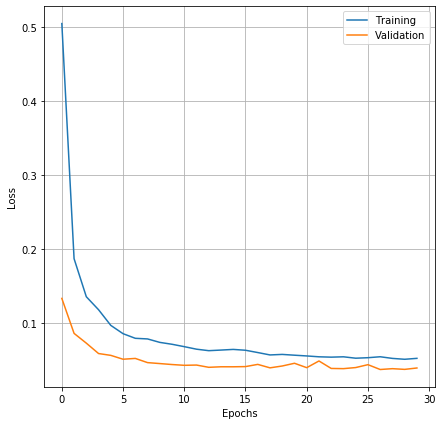

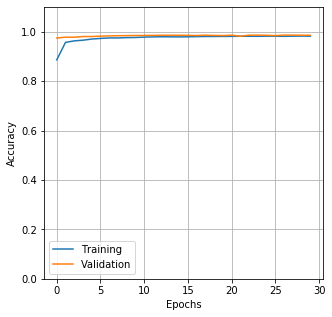

Predicting for train data
Elapsed time: 2.8170 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1080250
           1       0.96      0.95      0.96    196825
           2       0.82      0.66      0.73     13165

    accuracy                           0.99   1290240
   macro avg       0.92      0.87      0.89   1290240
weighted avg       0.99      0.99      0.99   1290240



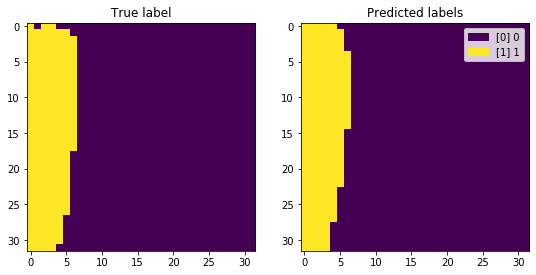

Predicting for test data
Elapsed time: 1.1955 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    455078
           1       0.97      0.94      0.96    122417
           2       0.76      0.67      0.71      6185

    accuracy                           0.98    583680
   macro avg       0.91      0.87      0.89    583680
weighted avg       0.98      0.98      0.98    583680



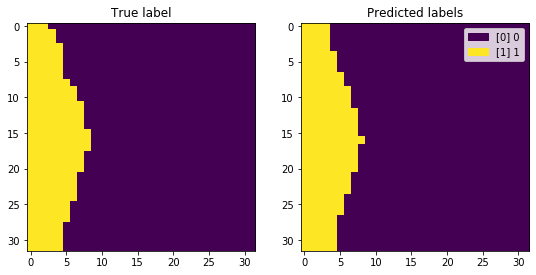

Elapsed time: 2.0333 seconds
Fasle positive blobs 3


In [15]:
spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [20]:
mypackage.report_count_false_positive(y_pred_test, Y_test)

Fasle positive blobs 34.
Fasle positive blobs per image 0.0596


### Test 2D UNet on the same data

(1260, 32, 32, 208)
Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.3610 - accuracy: 0.9458
Epoch 00001: val_loss improved from inf to 0.10564, saving model to latest_unet.hdf5
1134/1134 [==============================] - 8s 7ms/sample - loss: 0.3600 - accuracy: 0.9459 - val_loss: 0.1056 - val_accuracy: 0.9743
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9704
Epoch 00002: val_loss improved from 0.10564 to 0.09248, saving model to latest_unet.hdf5
1134/1134 [==============================] - 7s 6ms/sample - loss: 0.1222 - accuracy: 0.9704 - val_loss: 0.0925 - val_accuracy: 0.9752
Epoch 3/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9713
Epoch 00003: val_loss improved from 0.09248 to 0.07484, saving model to latest_unet.hdf5
1134/1134 [==============================] - 6s 6ms/sample - loss: 0.1022 - accuracy: 0.971

Epoch 28/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.9833
Epoch 00028: val_loss did not improve from 0.04793
1134/1134 [==============================] - 6s 6ms/sample - loss: 0.0495 - accuracy: 0.9833 - val_loss: 0.0486 - val_accuracy: 0.9826
Epoch 29/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9842
Epoch 00029: val_loss did not improve from 0.04793
1134/1134 [==============================] - 7s 6ms/sample - loss: 0.0466 - accuracy: 0.9842 - val_loss: 0.0490 - val_accuracy: 0.9823
Epoch 30/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9838
Epoch 00030: val_loss did not improve from 0.04793
1134/1134 [==============================] - 7s 6ms/sample - loss: 0.0471 - accuracy: 0.9838 - val_loss: 0.0493 - val_accuracy: 0.9824
Elapsed time: 200.5724 seconds


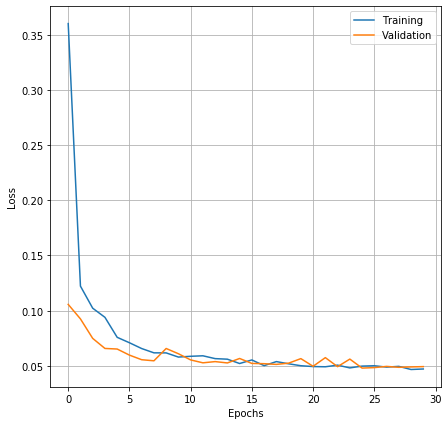

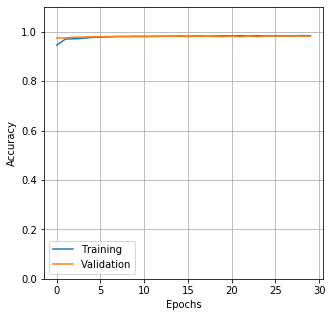

Predicting for train data
Elapsed time: 2.6053 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1049404
           1       0.95      0.97      0.96    226419
           2       0.85      0.53      0.65     14417

    accuracy                           0.98   1290240
   macro avg       0.93      0.83      0.87   1290240
weighted avg       0.98      0.98      0.98   1290240



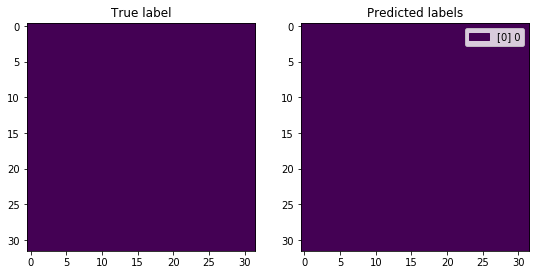

Predicting for test data
Elapsed time: 1.0607 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    454977
           1       0.96      0.96      0.96    121779
           2       0.74      0.60      0.66      6924

    accuracy                           0.98    583680
   macro avg       0.90      0.85      0.87    583680
weighted avg       0.98      0.98      0.98    583680



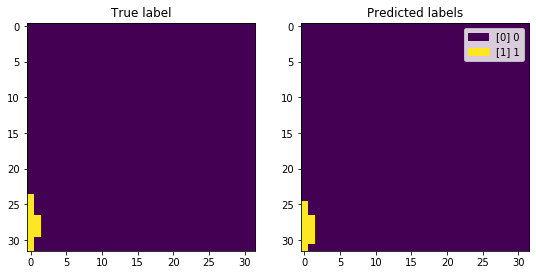

Elapsed time: 2.0207 seconds
Fasle positive blobs 46.
Fasle positive blobs per image 0.0807
Number of layers in the base model:  49


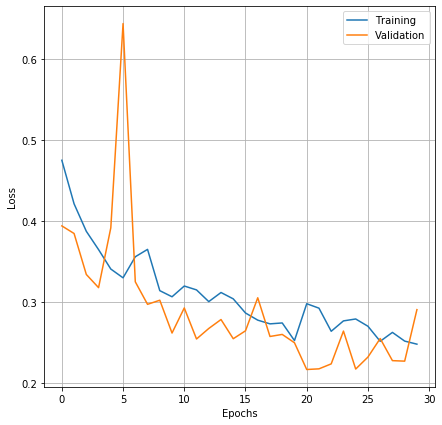

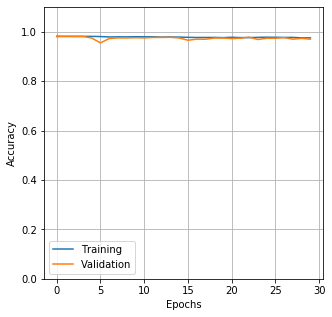

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 1.3177 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    454977
           1       0.99      0.87      0.92    121779
           2       0.67      0.79      0.72      6924

    accuracy                           0.97    583680
   macro avg       0.88      0.88      0.88    583680
weighted avg       0.97      0.97      0.97    583680



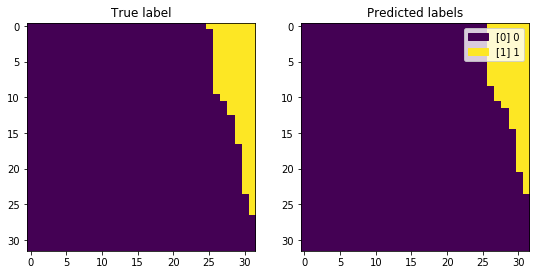

Fasle positive blobs 61.
Fasle positive blobs per image 0.1070


In [4]:
# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [] # [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    elif channels_used != []:
        return X_train[..., channels_used]
    else:
        return X_train
    
print(select_channels(X_train).shape)
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [5]:
# def get_classification_heat_map(y_hat, heat_maps):
#     heat = np.zeros(y_hat.shape)
#     heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
#     heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
#     heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
#     return heat

# def plot_with_heat_map(y_hat, heat_maps, y):
#     heat = get_classification_heat_map(y_hat, heat_maps)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(heat)
#     plt.colorbar()
#     plt.title("Model confidence of classification")
#     plt.subplot(132)
#     img = plt.imshow(y_hat)
#     mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
#     plt.title("Predicted labels")
#     plt.subplot(133)
#     img = plt.imshow(np.squeeze(y))
#     mypackage.Dataset._Dataset__add_legend_to_image(y, img)
#     plt.title("True labels")

# # y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
# for i in range(len(Y_test)):
#     if 2 in Y_test[i]:
#         plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
#         plt.suptitle(i)
        

Number of layers in the base model:  49


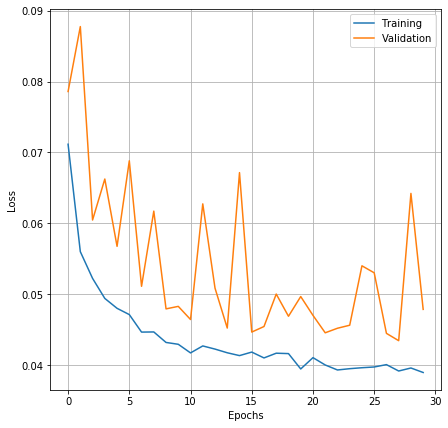

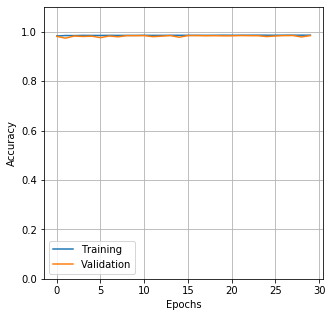

Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again
Elapsed time: 1.3212 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    454977
           1       0.97      0.96      0.97    121779
           2       0.70      0.75      0.73      6924

    accuracy                           0.99    583680
   macro avg       0.89      0.90      0.90    583680
weighted avg       0.99      0.99      0.99    583680



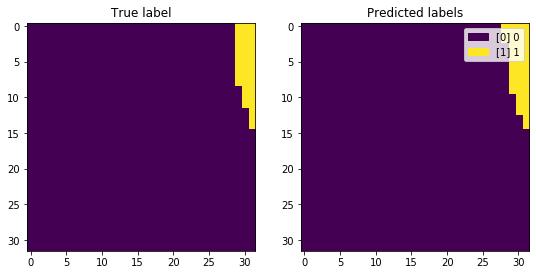

Fasle positive blobs 45.
Fasle positive blobs per image 0.0789


In [5]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [ ]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))